In [130]:
import pandas as pd

# Load Dataset

In [131]:
df = pd.read_csv("datasets/dataset.csv")
columns = list(df.columns)
Y_columns = ["program_name", "optimal_luf", "loop_line_number"]
input_features = [x for x in columns if x not in Y_columns]
X = df[input_features]
Y = df["optimal_luf"]

features = set(X.columns)

# Filter

In [132]:
frequency = Y.value_counts()
print(frequency)

optimal_luf
1    71
4    33
8    32
3    27
5    27
6    25
2    22
7    10
Name: count, dtype: int64


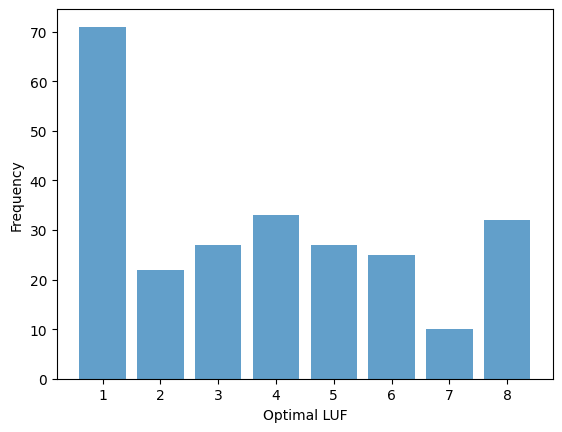

In [133]:
import matplotlib.pyplot as plt

# Extract keys and values from the dictionary
categories = list(dict(frequency).keys())
values = list(dict(frequency).values())

# Plot the histogram
plt.bar(categories, values, alpha=0.7)

# Add labels and title
plt.xlabel('Optimal LUF')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [134]:
Y = Y[Y.isin([1, 4, 8])]
Y_indices = list(Y.index)
X = X.loc[Y_indices]

frequency = Y.value_counts()
print(frequency)

optimal_luf
1    71
4    33
8    32
Name: count, dtype: int64


In [135]:
print(len(X))

136


# Train RF

In [136]:
from sklearn.datasets import fetch_covtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV as grid_search
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier

## Feature Selection

In [137]:
stop = False
best_score = 0
best_gsv = None
scores = list()
best_features = set()

curr_features = set()

while len(curr_features) < 5:
    print("\n====================")
    
    col_to_add = None
    best_curr_score = 0
    best_cur_gsv = None

    for column_name in (features - curr_features):
        print(f"Testing {column_name}")
        X_filtered = X[list(curr_features.union({column_name}))]

        clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
        params = {
            'kneighborsclassifier__n_neighbors': np.arange(1, 25),
            'kneighborsclassifier__weights': ['uniform', 'distance']
        }


        gsv = grid_search(clf, params, cv=5, n_jobs=-1, scoring='accuracy')
        gsv.fit(X_filtered, Y)

        if gsv.best_score_ > best_curr_score:
            best_curr_score = gsv.best_score_
            col_to_add = column_name
            best_cur_gsv = gsv
        
        print(f"Score: {gsv.best_score_}")

    if best_curr_score > best_score:
        best_score = best_curr_score
        best_gsv = best_cur_gsv
        curr_features.add(col_to_add)
        scores.append(best_curr_score)
        best_features = curr_features
        print(f"Found best!")
        print(f"Curr features: {curr_features}")
        print(f"Best score: {best_score}")

    elif abs(best_curr_score - best_score) >= 0.05:
        stop = True

    else:
        curr_features.add(col_to_add)
        scores.append(best_curr_score)
        print(f"Curr features: {curr_features}")
        print(f"Curr score: {best_curr_score}")
        print(f"Best score: {best_score}")



        



Testing intra_loop_dependencies_anti
Score: 0.5148148148148148
Testing intra_loop_dependencies_flow
Score: 0.5142857142857142
Testing max_inter_loop_dependency_distance_anti
Score: 0.521957671957672
Testing alui
Score: 0.5291005291005291
Testing branch
Score: 0.521957671957672
Testing mem
Score: 0.5367724867724868
Testing max_intra_loop_dependency_distance_output
Score: 0.521957671957672
Testing max_inter_loop_dependency_distance_output
Score: 0.521957671957672
Testing max_intra_loop_dependency_distance_anti
Score: 0.521957671957672
Testing load
Score: 0.521957671957672
Testing inter_loop_dependencies_output
Score: 0.5145502645502645
Testing array_reads
Score: 0.521957671957672
Testing operand_sum
Score: 0.5367724867724868
Testing aluf
Score: 0.521957671957672
Testing loop_nest_level
Score: 0.523015873015873
Testing resmii_121
Score: 0.5359788359788359
Testing other
Score: 0.5145502645502645
Testing resmii_111
Score: 0.4843915343915343
Testing array_writes
Score: 0.521957671957672
Tes

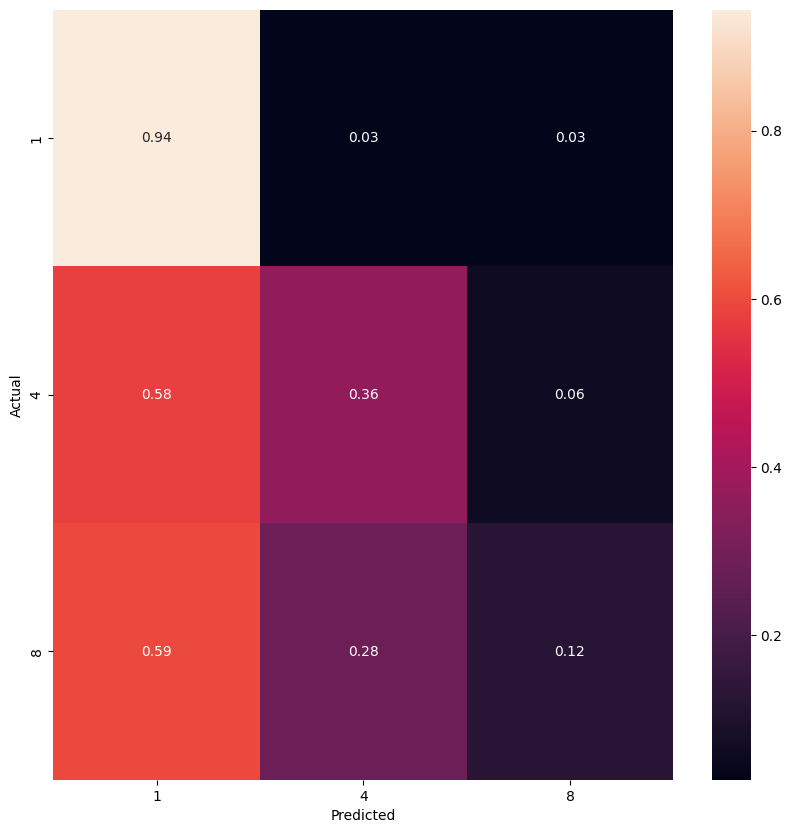

In [138]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cv_predictions = cross_val_predict(best_gsv.best_estimator_, X_filtered, Y, cv=5, n_jobs=-1)

cm = confusion_matrix(Y, cv_predictions)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.unique(Y), yticklabels=np.unique(Y))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [139]:
print(gsv.best_params_)
print(best_features)

{'kneighborsclassifier__n_neighbors': 2, 'kneighborsclassifier__weights': 'uniform'}
{'max_inter_loop_dependency_distance_output', 'load', 'mem', 'max_intra_loop_dependency_distance_output', 'loop_nest_level'}


In [140]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(f"Acc1: {best_score}")
precision = precision_score(Y, cv_predictions, average='weighted')
recall = recall_score(Y, cv_predictions, average='weighted')
f1 = f1_score(Y, cv_predictions, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Acc1: 0.6103174603174603
Precision: 0.577368773596395
Recall: 0.6102941176470589
F1: 0.548527024446142


In [142]:
avg_err = 0
Y_list = list(Y)

for i in range(len(cv_predictions)):
    pred = cv_predictions[i]
    true = Y_list[i]
    avg_err += abs(pred-true)

avg_err /= len(cv_predictions)

print(f"Average error = {avg_err}")

Average error = 1.8676470588235294


# Comparison

In [ ]:
X_filtered = X[["operand_sum", "instruction_sum", "trip_count"]]

clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
params = {
    'kneighborsclassifier__n_neighbors': np.arange(1, 25),
    'kneighborsclassifier__weights': ['uniform', 'distance']
}


gsv = grid_search(clf, params, cv=5, n_jobs=-1, scoring='accuracy')
gsv.fit(X_filtered, Y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24]),
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             scoring='accuracy')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
cv_predictions = cross_val_predict(gsv.best_estimator_, X_filtered, Y, cv=5, n_jobs=-1)
print(f"Acc1: {best_score}")
precision = precision_score(Y, cv_predictions, average='weighted')
recall = recall_score(Y, cv_predictions, average='weighted')
f1 = f1_score(Y, cv_predictions, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Acc1: 0.6103174603174603
Precision: 0.43653250773993807
Recall: 0.5294117647058824
F1: 0.3852364475201846


/Users/meharsingh/Documents/compilers/compilers_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


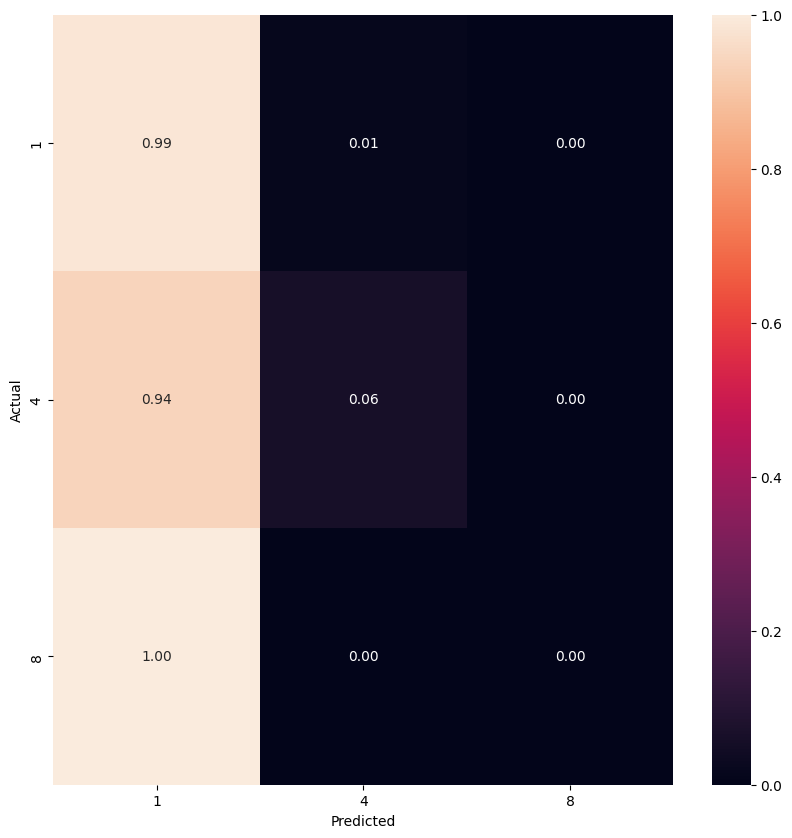

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(Y, cv_predictions)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.unique(Y), yticklabels=np.unique(Y))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
avg_err = 0
Y_list = list(Y)

for i in range(len(cv_predictions)):
    pred = cv_predictions[i]
    true = Y_list[i]
    avg_err += abs(pred-true)

avg_err /= len(cv_predictions)

print(f"Average error = {avg_err}")

[1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1]
0      1
1      1
2      8
3      4
7      1
      ..
241    1
242    1
244    1
245    1
246    1
Name: optimal_luf, Length: 136, dtype: int64
